<a href="https://colab.research.google.com/github/tumble-weed/seq2seq/blob/master/Seq2Seq_for_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Learning Takeaways:**
- torchtext
- what is bucketiterator
- Make InitHidden


In [2]:
!pip install -I --no-cache-dir pillow

     |████████████████████████████████| 2.0MB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


spacy for tokenization, tuning a string lump into individual words

In [0]:
import torch
import torchtext

import spacy
import numpy as np
import random,math,time
import tqdm
from termcolor import colored
from matplotlib import pyplot as plt

tensor_to_numpy = lambda t:t.detach().cpu().numpy()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
#for reproducibility
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

will need to download the de package for making a german tokenizer

In [5]:
!python -m spacy download de

     |████████████████████████████████| 38.2MB 1.2MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-mi_lu0d4/wheels/a5/9e/96/785f498e5cea276b337aab8a79259d32a93f03bd744d71eef5
Successfully built de-core-news-sm

    Linking successful
    /usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/de

    You can now load the model via spacy.load('de')



load the english and german languages and make tokenizers

In [0]:
spacy_de,spacy_en = spacy.load('de'),spacy.load('en')


In [0]:
# reverse returns the words in reverse order
# original seq2seq works better with words in target language reversed
def tokenize_de(text,reverse=False):
    tokenized = [tok.text for tok in spacy_de.tokenizer(text)]
    return  tokenized[::-1] if reverse else tokenized

def tokenize_en(text,reverse=False):
    tokenized = [tok.text for tok in spacy_en.tokenizer(text)]
    return  tokenized[::-1] if reverse else tokenized


torchtext.data is the nlp version of torchvision transforms.
- it takes in a tokenizer for returning words from strings
- defines the START and END tokens
- converts everything to lowercase

In [0]:
source = torchtext.data.Field(tokenize = lambda text:tokenize_de(text,
                                                                reverse=True),
                             init_token = '<init>',
                             eos_token = '<eos>',
                              lower = True
                             )
#TODO target
target = torchtext.data.Field(tokenize = tokenize_en,
                             init_token = '<init>',
                             eos_token = '<eos>',
                             lower= True)


Make dataset splits from Multi30k

In [9]:
train_data,valid_data,test_data = torchtext.datasets.Multi30k.splits(exts= ('.de','.en'),
                                                                    fields = (source, target))


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 654kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 227kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 218kB/s]


In [10]:
print(f'train len:{len(train_data.examples)}\n valid len: {valid_data.examples.__len__()}\n test data: {test_data.examples.__len__()}')

train len:29000
 valid len: 1014
 test data: 1000


In [11]:
vars.__doc__

'vars([object]) -> dictionary\n\nWithout arguments, equivalent to locals().\nWith an argument, equivalent to object.__dict__.'

In [14]:
print(train_data.examples[0].__dict__) # __dict__ has the 'src' and 'trg' keys which hold the sentences

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


Build the vocabulary for the source and the target

In [0]:
# min_freq culls words that only occur once
source.build_vocab(train_data,min_freq = 2) # tokenize_de will only return words from german
target.build_vocab(train_data,min_freq = 2)

**Encoder**

In [0]:
class Encoder(torch.nn.Module):
    def __init__(self,
                 input_len,
                embedding_len,
                hidden_len,
                 n_layers,
                dropout_p):
        
        super(Encoder,self).__init__()
        
        self.n_layers = n_layers
        self.embed  = torch.nn.Embedding(input_len,
                                        embedding_len)
        self.post_embedding_dropout = torch.nn.Dropout(dropout_p)
        self.rnn = torch.nn.LSTM(embedding_len,
                                hidden_len,
                                 n_layers,
                                 dropout=dropout_p
                                )
        
        self.input_len,self.embedding_len,self.hidden_len = input_len,embedding_len,hidden_len
        
        pass
    
    def forward(self,x):
        embedded_x = self.embed(x)
        embedded_x = self.post_embedding_dropout(embedded_x)
        
        rnn_out,(rnn_hidden,rnn_cell) = self.rnn(embedded_x)
        
        return rnn_hidden, rnn_cell
        pass

**Decoder**

In [0]:
class Decoder(torch.nn.Module):
    def __init__(self,
                input_len,
                embedding_len,
                hidden_len,
                n_layers,
                dropout_p):
        
        super(Decoder,
              self).__init__()
        
        self.n_layers = n_layers
        
        self.embed = torch.nn.Embedding(input_len,
                                       embedding_len)
        self.post_embed_dropout = torch.nn.Dropout(dropout_p)
        
        self.rnn = torch.nn.LSTM(embedding_len,
                                 hidden_len,
                                 n_layers,
                                 dropout = dropout_p
                                )
        
        self.out = torch.nn.Linear(hidden_len,
                                  input_len)
        
        self.input_len,self.embedding_len,self.hidden_len = input_len,embedding_len,hidden_len
        
        pass
    def forward(self,
                x,
                hidden,
                cell):
        #what is x here? <sos>
        #start with the hidden and the cell of the encoder 
        x = x.unsqueeze(0) # x is just batch_size*vocab_len. Add an extra 1 in the seq_len dim 
        embedded_x = self.post_embed_dropout(self.embed(x))
        pre_outputs,(hidden,cell) = self.rnn(embedded_x,(hidden,cell))
        outputs = self.out(pre_outputs.squeeze(0)) #remove the seq_len  which will be 1 if you run this time step by time step
        return outputs,hidden,cell
        pass

**Make a Seq2Seq container to connect Encoder-Decoder**

In [0]:


'''
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs
'''



'\nclass Seq2Seq(nn.Module):\n    def __init__(self, encoder, decoder, device):\n        super().__init__()\n        \n        self.encoder = encoder\n        self.decoder = decoder\n        self.device = device\n        \n        assert encoder.hid_dim == decoder.hid_dim,             "Hidden dimensions of encoder and decoder must be equal!"\n        assert encoder.n_layers == decoder.n_layers,             "Encoder and decoder must have equal number of layers!"\n        \n    def forward(self, src, trg, teacher_forcing_ratio = 0.5):\n        \n        #src = [src sent len, batch size]\n        #trg = [trg sent len, batch size]\n        #teacher_forcing_ratio is probability to use teacher forcing\n        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time\n        \n        batch_size = trg.shape[1]\n        max_len = trg.shape[0]\n        trg_vocab_size = self.decoder.output_dim\n        \n        #tensor to store decoder outputs\n        outputs = torch.

In [0]:
class Seq2Seq(torch.nn.Module):
    def __init__(self,
                 encoder,
                decoder,
                device):
        super(Seq2Seq,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        ''' some checks for consistency '''
        assert encoder.hidden_len == decoder.hidden_len , 'hidden shapes of encoder and decoder do not match'
        assert encoder.n_layers == decoder.n_layers , 'number of layers of encoder and decoder do not match'
        
        pass
    
    def forward(self,
                src,
               trg,
               teacher_forcing_ratio = 0.5):
        max_seq_len,batch_size,trg_vocab_len = trg.shape[0],trg.shape[1],self.decoder.input_len 
        #? will trg.shape[-1] not be trg_vocab_len
        
        outputs = torch.zeros(max_seq_len,batch_size,trg_vocab_len).to(self.device)
        
        encoder_hidden,encoder_cell = self.encoder(src)
        
        
        decoder_input = trg[0,:] # first word of all batches  = <sos>
        decoder_hidden,decoder_cell = encoder_hidden,encoder_cell
        for t in range(1, max_seq_len):
            pred, decoder_input,decoder_cell = self.decoder(decoder_input,encoder_hidden,encoder_cell)
            outputs[t] = pred
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = pred.max(1)[1]
            decoder_input = trg[t] if teacher_force else top1
        return outputs

**Make the data loaders**

In [0]:
BATCH_SIZE = 128
train_loader,valid_loader,test_loader = torchtext.data.BucketIterator.splits((train_data,
                                                                           valid_data,
                                                                           test_data),
                                                                          batch_size = BATCH_SIZE,
                                                                          device = device)


**Make the models**

In [0]:
SRC_VOCAB_LEN,TGT_VOCAB_LEN = len(source.vocab),len(target.vocab)
HIDDEN_DIM = 512
ENC_EMBEDDING_LEN,DEC_EMBEDDING_LEN = 256,256
N_LAYERS = 2
ENC_DROPOUT,DEC_DROPOUT = 0.5,0.5

enc,dec = Encoder(SRC_VOCAB_LEN,ENC_EMBEDDING_LEN,HIDDEN_DIM,N_LAYERS,ENC_DROPOUT),Decoder(TGT_VOCAB_LEN,DEC_EMBEDDING_LEN,HIDDEN_DIM,N_LAYERS,DEC_DROPOUT) 
model = Seq2Seq(enc,
                dec,
                device,
               )
model.to(device),enc.to(device),dec.to(device)

(Seq2Seq(
   (encoder): Encoder(
     (embed): Embedding(7853, 256)
     (post_embedding_dropout): Dropout(p=0.5)
     (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
   )
   (decoder): Decoder(
     (embed): Embedding(5893, 256)
     (post_embed_dropout): Dropout(p=0.5)
     (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
     (out): Linear(in_features=512, out_features=5893, bias=True)
   )
 ), Encoder(
   (embed): Embedding(7853, 256)
   (post_embedding_dropout): Dropout(p=0.5)
   (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
 ), Decoder(
   (embed): Embedding(5893, 256)
   (post_embed_dropout): Dropout(p=0.5)
   (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
   (out): Linear(in_features=512, out_features=5893, bias=True)
 ))

In [0]:
'''
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)
'''

'\ndef init_weights(m):\n    for name, param in m.named_parameters():\n        nn.init.uniform_(param.data, -0.08, 0.08)\n        \nmodel.apply(init_weights)\n'

In [0]:
for name,p in model.named_parameters():
#     if name.find('bias')  == -1:
      if True:
        torch.nn.init.uniform_(p.data,
                              -0.08,
                              0.08)

In [0]:
n_params = 0
for m in model.children():
    for p in m.parameters():
        n_params += p.numel()
print(f'number of parameters:{n_params}')


number of parameters:13898501


In [0]:
PAD_IDX = target.vocab.stoi['<pad>']
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

**Training**

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'through', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



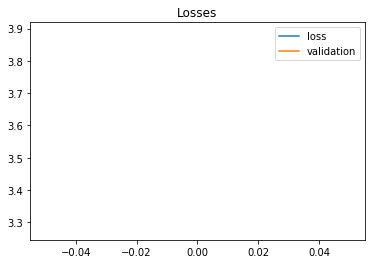

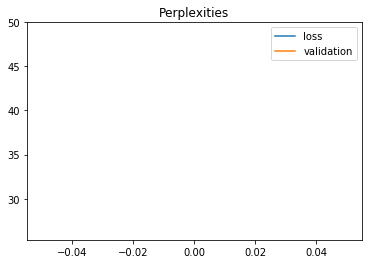

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'through', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



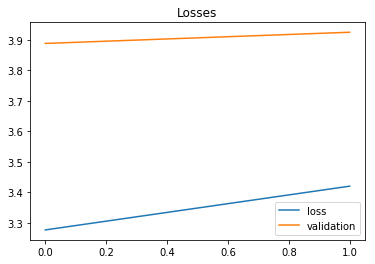

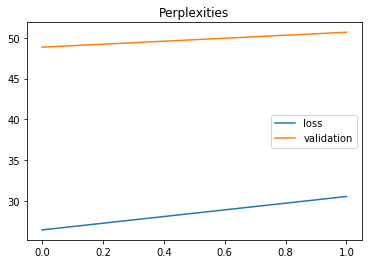

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'in', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



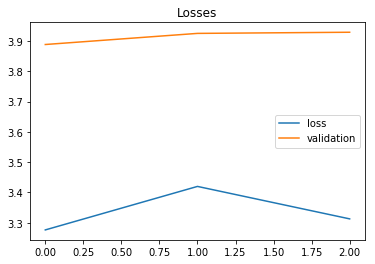

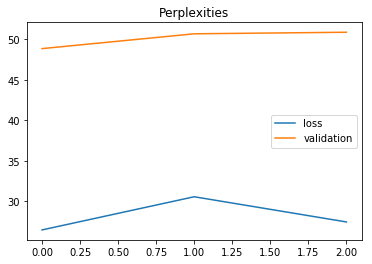

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'in', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



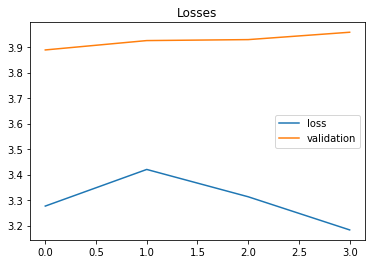

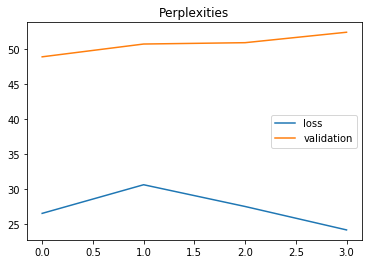

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'in', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



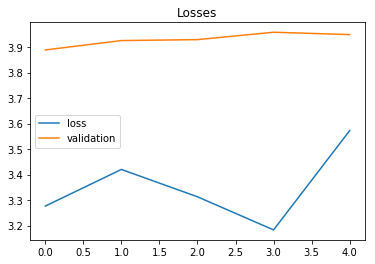

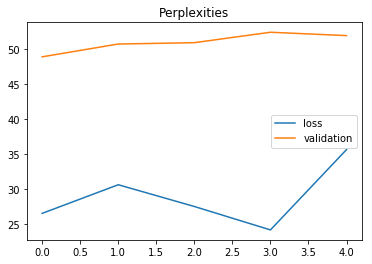

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'in', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



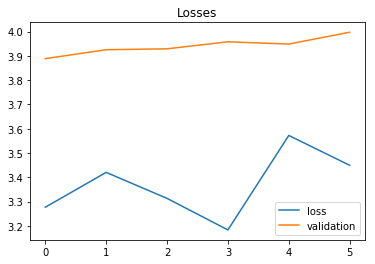

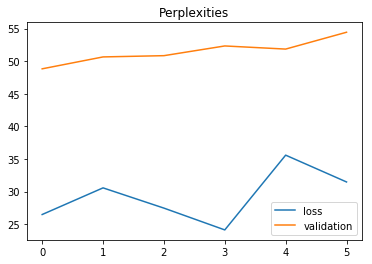

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'in', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



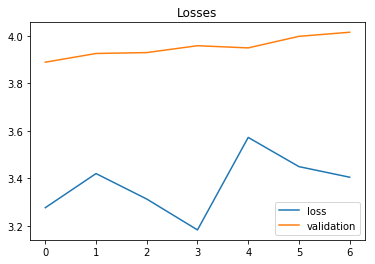

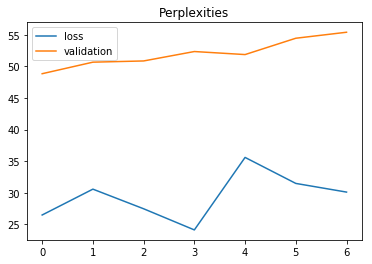

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'in', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



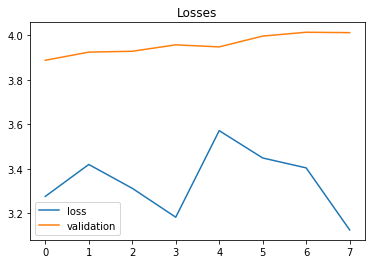

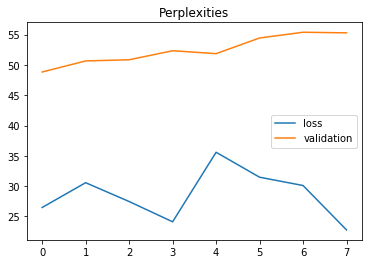

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'in', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



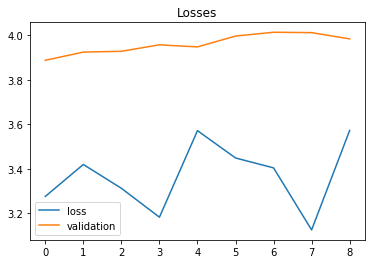

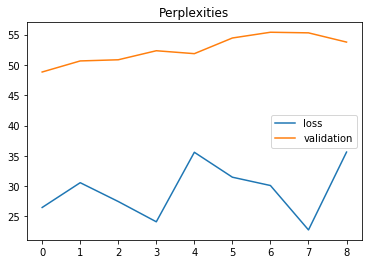

0 torch.Size([13, 128]) torch.Size([13, 128])
0 torch.Size([1536, 5893]) torch.Size([1536])

['<init>', '.', 'schnee', 'den', 'über', 'laufen', 'hunde', 'mittelgroße', 'zwei', '<eos>'] 
 ['<init>', 'two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>'] 
 ['<unk>', 'two', 'dogs', 'running', 'in', 'the', 'snow', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>'] 



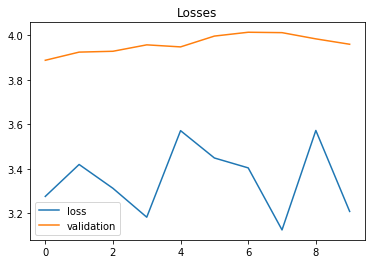

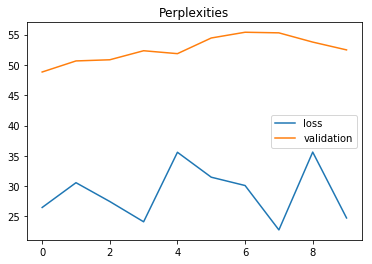

In [0]:
model.train()

opt = torch.optim.Adam(model.parameters())
nepochs = 10
viz_every = 1
trends = {'loss':[],
          'validation':[],
         }

for e in range(nepochs):
    partial = {'loss':0.,'validation':0.}
    for bi,b in enumerate(tqdm.tqdm_notebook(train_loader)):
        bx,by = b.src,b.trg
        bx,by = bx.to(device),by.to(device)

        bpred = model(bx,by)    # bpred shape is (by_seq_len,batch_size,trg_vocab_len)
                                # by shape is (by_seq_len, batch_size)

        bpred,by = bpred[1:],by[1:] #remove the <init> token
        
        
        
        # reshape for a classification loss, 
        # bpred is made into (batch_size*seq_len) X target_vocab_len
        # bpred is made into (batch_size*seq_len) X 1
        
        bpred,by = bpred.view(-1,bpred.shape[-1]),by.view(-1)
        
        loss = criterion(bpred,by) 
        
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1)
        
        opt.step()
        
        partial['loss'] += tensor_to_numpy(loss)
#         break

        
    trends['loss'].append(partial['loss']/(bi+1.))
    if e%viz_every == 0:
        was_training = model.training
        model.eval()
        with torch.no_grad():
            for val_bi,val_b in enumerate(tqdm.tqdm_notebook(valid_loader)):
                val_bx,val_by = val_b.src,val_b.trg
                val_bx,val_by = val_bx.to(device),val_by.to(device)


                
                dummy_by = torch.zeros_like(val_by)
                dummy_by[0,:] = target.vocab.stoi['<init>'] # retain the first word as <init>
                dummy_by[1:,:] = target.vocab.stoi['<pad>'] # make everything else as <pad>

                print(val_bi,
                      dummy_by.shape,
                     val_by.shape)

                
                
                val_pred = model(val_bx,
                                 dummy_by,
                                 teacher_forcing_ratio = 0.)
                
                val_pred,val_by = val_pred[1:],val_by[1:] #remove the <init>  token
                val_pred,val_by = val_pred.view(-1,val_pred.shape[-1]),val_by.view(-1)
                
                print(val_bi,
                      val_pred.shape,
                     val_by.shape)
                
                val_loss = criterion(val_pred,val_by)
                partial['validation'] += val_loss
#                 break
            trends['validation'].append(partial['validation'] / (val_bi+1.))
            
            '''See a sample'''
            
            test_batch = next(iter(test_loader))
            test_src,test_trg = test_batch.src,test_batch.trg

            dummy_trg = torch.zeros_like(test_trg)
            dummy_trg[0,:] = test_trg[0,:]

            test_pred = model(test_src,
                 dummy_trg,
                 teacher_forcing_ratio = False)

            print([source.vocab.itos[i] for i in  test_src[:,0]],'\n',
              colored([target.vocab.itos[i] for i in  test_trg[:,0]],'blue'),'\n',
              colored([target.vocab.itos[i] for i in  test_pred.max(-1)[1][:,0]],'green'),'\n',)


        
        if was_training:
            model.train()
            
        plt.figure()
        plt.plot(trends['loss'],label='loss')
        plt.plot(trends['validation'],label = 'validation')
        plt.legend()
        plt.title('Losses')
        plt.show()

        plt.figure()
        plt.plot(np.exp(trends['loss']),label='loss')
        plt.plot(np.exp(trends['validation']),label = 'validation')
        plt.legend()
        plt.title('Perplexities')
        plt.show()
        

        pass
    pass